**Dogs vs Cats Classifier**\
I am trying to build a model that can differentiate between a ***dog***,***cat***, and also ***unindentified*** object

In [1]:
# using fastbook
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 5.4 MB/s 
     |████████████████████████████████| 1.2 MB 40.1 MB/s 
     |████████████████████████████████| 197 kB 33.8 MB/s 
     |████████████████████████████████| 60 kB 6.6 MB/s 
Mounted at /content/gdrive


In [2]:
# import all libraries -- not a good a way but it should work for now
from fastbook import *
from fastai.vision.widgets import *

In [3]:
# connect to the AZURE key
key = os.environ.get('AZURE_SEARCH_KEY', 'cd9885bcf25c4585956668a4e247e37d')

In [4]:
search_images_bing

<function fastbook.search_images_bing>

In [6]:
# search for an image
results = search_images_bing(key, 'cats')
ims = results.attrgot('contentUrl')
ims
print('Images length: ', len(ims))

Images length:  150


In [7]:
# download an image
dest = 'images/cats.jpg'
download_url(ims[0], dest)

Path('images/cats.jpg')

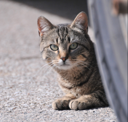

In [8]:
# view an image
im = Image.open(dest)
im.to_thumb(128,128)

In [9]:
# form list of images to use and create a place to store it
entities = ['cats', 'dogs', 'human face']
path = Path('entities')

In [10]:
# make a directory to store all images
if not path.exists():
    path.mkdir()
    for e in entities:
        dest = (path/e)
        dest.mkdir(exist_ok=True) 
        results = search_images_bing(key, f'{e} entity')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [11]:
# get image files
fns = get_image_files(path)
fns

(#403) [Path('entities/cats/00000060.jpg'),Path('entities/cats/00000085.jpg'),Path('entities/cats/00000095.jpg'),Path('entities/cats/00000144.jpg'),Path('entities/cats/00000105.png'),Path('entities/cats/00000024.png'),Path('entities/cats/00000020.jpg'),Path('entities/cats/00000001.jpg'),Path('entities/cats/00000140.png'),Path('entities/cats/00000110.jpg')...]

In [17]:
# check for broken images
failed = verify_images(fns)
print('Failed images: ', failed)
print('Failed images length: ', len(failed))

Failed images:  [Path('entities/cats/00000095.jpg'), Path('entities/cats/00000097.jpg'), Path('entities/cats/00000046.png'), Path('entities/cats/00000086.jpg'), Path('entities/cats/00000030.jpg'), Path('entities/human face/00000113.jpg'), Path('entities/human face/00000121.jpeg'), Path('entities/human face/00000022.png'), Path('entities/human face/00000011.jpg'), Path('entities/human face/00000140.jpg'), Path('entities/human face/00000133.jpg'), Path('entities/human face/00000014.png'), Path('entities/dogs/00000030.jpg')]
Failed images length:  13


In [19]:
# remove the broken images
failed.map(Path.unlink);

(#13) [Path('entities/cats/00000095.jpg'),Path('entities/cats/00000097.jpg'),Path('entities/cats/00000046.png'),Path('entities/cats/00000086.jpg'),Path('entities/cats/00000030.jpg'),Path('entities/human face/00000113.jpg'),Path('entities/human face/00000121.jpeg'),Path('entities/human face/00000022.png'),Path('entities/human face/00000011.jpg'),Path('entities/human face/00000140.jpg')...]

In [76]:
# join each image and its label in a block
entities = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [77]:
entities

In [78]:
# we need to load our datablock
dls = entities.dataloaders(path)

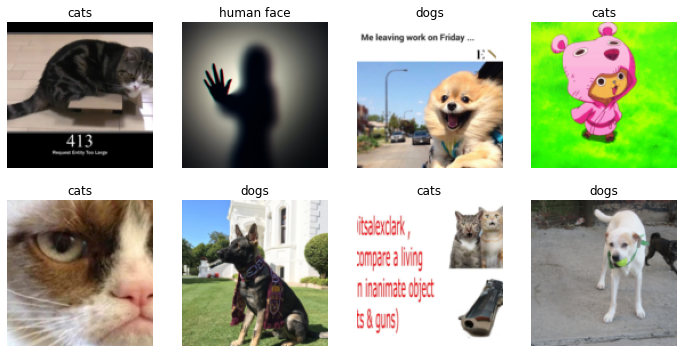

In [79]:
dls.valid.show_batch(max_n=8, nrows=2)

In [80]:
entities = entities.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = entities.dataloaders(path)

In [108]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.090089,3.245326,0.604651,00:08


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,1.684294,1.939833,0.558140,00:09
1,1.346979,0.955050,0.348837,00:08
2,1.054362,0.665296,0.255814,00:08
3,0.919243,0.526556,0.232558,00:08


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

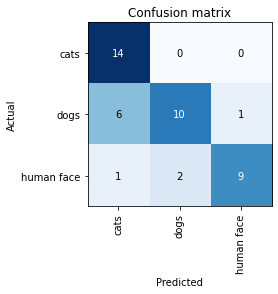

In [109]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

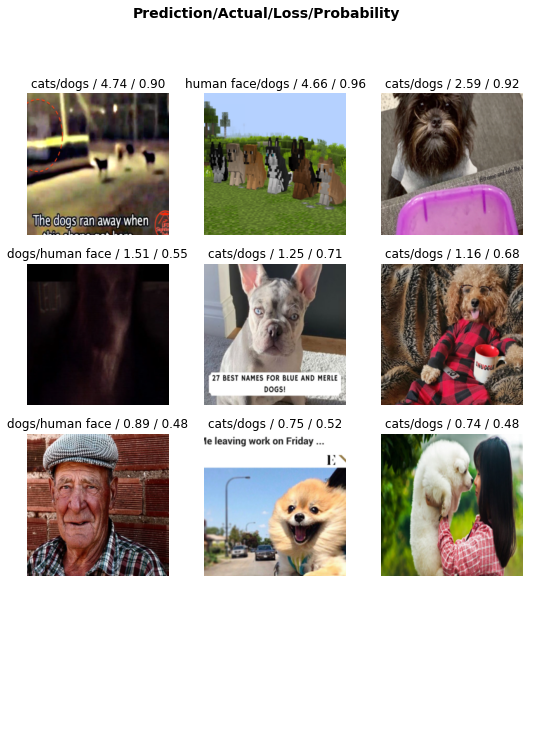

In [128]:
interp.plot_top_losses(12, nrows=4)

In [88]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [74]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,path_to_move in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/path_to_move)

In [111]:
# export the model
learn.export()

In [112]:
# check if the model has been created
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

Let's now test our model

In [113]:
learn_inf = load_learner(path/'export.pkl')

In [114]:
pth = Path('images')
dl = pth.ls()
for image in dl:
  if not image.name == '.ipynb_checkpoints': 
    print('Image Name: ', image.name, ' Prediction: ', learn_inf.predict(image))
# learn_inf.predict('images/dp_pic.jpg')

Image Name:  girl_face.jpg  Prediction:  ('human face', TensorBase(2), TensorBase([1.0103e-01, 6.9059e-05, 8.9890e-01]))


Image Name:  cats.jpg  Prediction:  ('cats', TensorBase(0), TensorBase([9.9894e-01, 8.5978e-04, 2.0124e-04]))


Image Name:  dp_pic.jpg  Prediction:  ('human face', TensorBase(2), TensorBase([0.0023, 0.0012, 0.9965]))


Image Name:  many_matured_faces.jpg  Prediction:  ('human face', TensorBase(2), TensorBase([1.1811e-03, 8.5726e-04, 9.9796e-01]))


Image Name:  neymarr.png  Prediction:  ('human face', TensorBase(2), TensorBase([1.0750e-03, 9.5219e-07, 9.9892e-01]))


Image Name:  puppies_draw.png  Prediction:  ('human face', TensorBase(2), TensorBase([0.3722, 0.0207, 0.6071]))


Image Name:  pup.jpg  Prediction:  ('dogs', TensorBase(1), TensorBase([0.2790, 0.6307, 0.0903]))


Image Name:  weird_cat_drawing.png  Prediction:  ('human face', TensorBase(2), TensorBase([0.1229, 0.0263, 0.8508]))


Image Name:  face_test.jpg  Prediction:  ('human face', TensorBase(2), TensorBase([0.1036, 0.0070, 0.8895]))


Image Name:  many_dogs.jpeg  Prediction:  ('dogs', TensorBase(1), TensorBase([2.2479e-04, 9.9371e-01, 6.0607e-03]))


Image Name:  cat_cartoon.png  Prediction:  ('human face', TensorBase(2), TensorBase([0.4273, 0.0010, 0.5717]))


Image Name:  cartoon_faces.jpg  Prediction:  ('human face', TensorBase(2), TensorBase([6.7737e-02, 3.7906e-04, 9.3188e-01]))


In [115]:
learn_inf.dls.vocab

['cats', 'dogs', 'human face']